# **코사인 유사도 practice**

#### 코사인 유사도 반환 함수

```
# 코드로 형식 지정됨
```



In [5]:
import numpy as np

def cos_similarity(v1, v2):
  dot_product = np.dot(v1, v2)
  l2_norm = (np.sqrt(sum(np.square(v1))) + np.sqrt(sum(np.square(v2))))
  similarity = dot_product / l2_norm

  return similarity

#### TF-IDF 벡터화와 비교

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vec = TfidfVectorizer()
feature_vec = tfidf_vec.fit_transform(doc_list)
print(feature_vec.shape)

(3, 18)


In [12]:
print(type(feature_vec))

<class 'scipy.sparse.csr.csr_matrix'>


In [13]:
# feature_vec가 Sparse Matrix이므로 Dense Matrix로 변환
feature_vec_dense = feature_vec.todense()

# 첫번째 문장 feature vector 추출
vec1 = np.array(feature_vec_dense[0]).reshape(-1,)
# 두번째 문장 feature vector 추출
vec2 = np.array(feature_vec_dense[1]).reshape(-1,)

# 코사인 유사도
similarity_12 = cos_similarity(vec1, vec2)
print(similarity_12)

0.20103879107475067


In [15]:
vec1 = np.array(feature_vec_dense[0]).reshape(-1,)
vec3 = np.array(feature_vec_dense[2]).reshape(-1,)
similarity_13 = cos_similarity(vec1, vec3 )
print(similarity_13)

vec2 = np.array(feature_vec_dense[1]).reshape(-1,)
vec3 = np.array(feature_vec_dense[2]).reshape(-1,)
similarity_23 = cos_similarity(vec2, vec3 )
print(similarity_23)

0.2021252238797431
0.22823648013083198


#### 사이킷런 코사인 유사도 함수

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_pair = cosine_similarity(feature_vec[0], feature_vec)
print(similarity_pair)

[[1.         0.40207758 0.40425045]]


In [17]:
similarity_pair = cosine_similarity(feature_vec, feature_vec)
print(similarity_pair)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]


# **Opinion Review 문서 유사도**

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

# 구두점 목록
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [28]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import nltk
nltk.download('punkt')
nltk.download('wordnet')

path = '/content/drive/MyDrive/data/OpinosisDataset1.0/topics/'
all_files = glob.glob(os.path.join(path, "*.data"))

filename_list = []
opinion_text = []

for file_ in all_files:
  df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')

  # file 명 가공
  filename_ = file_.split('/')[-1]
  filename = filename_.split('.')[0]

  # 파일명 리스트
  filename_list.append(filename)
  # 파일 내용 리스트
  opinion_text.append(df.to_string())

# 파일명 리스트, 파일내용 리스트 DataFrame화
document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vec = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                            ngram_range=(1,2), min_df=0.05, max_df=0.85)
feature_vec = tfidf_vec.fit_transform(document_df['opinion_text'])

# KMean 클러스터링
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vec)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


#### 호텔로 클러스터링 된 문서들의 코사인 유사도

In [36]:
hotel_indexes = document_df[document_df['cluster_label']==1].index
print("호텔로 클러스터링 된 문서들의 DataFrame index:\n", hotel_indexes)

# 호텔로 클러스터링 된 첫번째 데이터 파일명
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print("문서명 : ", comparison_docname)

similarity_pair = cosine_similarity(feature_vec[hotel_indexes[0]], feature_vec[hotel_indexes])
print(similarity_pair)

호텔로 클러스터링 된 문서들의 DataFrame index:
 Int64Index([20, 22, 23, 24, 29, 30, 33, 35, 36, 39, 40, 41, 42, 43, 44, 47], dtype='int64')
문서명 :  service_swissotel_hotel_chicago
[[1.         0.44807817 0.89622717 0.24657221 0.37631406 0.27745184
  0.19635836 0.26055029 0.3220525  0.11365035 0.1307754  0.1386783
  0.19000232 0.23839291 0.85133351 0.38250699]]


[[ 2 14  1 15  4  8  5  7  3 13  6 12 11 10  9]]


Text(0.5, 1.0, 'service_swissotel_hotel_chicago')

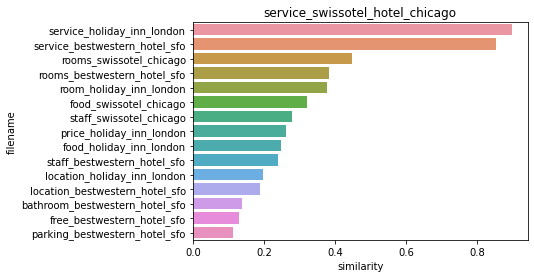

In [43]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sorted_index = similarity_pair.argsort()[:,::-1]
# 자기 자신 제외
sorted_index = sorted_index[:, 1:]
print(sorted_index)

# 유사도 큰 순으로 호텔 인덱스 재정렬
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1,)]

# 유사도 큰 순으로 유사도 값 재정렬
hotel_1_similarity = np.sort(similarity_pair.reshape(-1,))[::-1]
# 자기 자신 제외
hotel_1_similarity = hotel_1_similarity[1:]

# 시각화
hotel_1_similarity_df = pd.DataFrame()
hotel_1_similarity_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_similarity_df['similarity'] = hotel_1_similarity

sns.barplot(x='similarity', y='filename', data=hotel_1_similarity_df)
plt.title(comparison_docname)